Proyecto 1

Imanol Muñiz Ramirez A01701713

María José Soto

Rodrigo

Provide understanding of the candy category by manufacturermarket share composition by year

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df_catalog = pd.read_csv('./DATA_CATALOG_2024.csv', encoding='latin1')
df_sales = pd.read_csv('./DATOS_VENTA_2024.csv')

Limpieza y merge de los datos

In [3]:
# Quitar símbolo de $ y comas, convertir a numérico
df_sales['VALOR'] = (
    df_sales['VALOR']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Agregar por ID y ANIO ---
df_yearly = (
    df_sales
    .groupby(['ID','ANIO'], as_index=False)['VALOR']
    .sum()   # suma del valor anual por producto
)

# --- Pivot: IDs en filas, años en columnas ---
df_pivot = df_yearly.pivot(index='ID', columns='ANIO', values='VALOR').reset_index()

# Renombrar columnas a string (opcional)
df_pivot.columns = [str(c) for c in df_pivot.columns]

# Merge con catálogo
df_final = df_catalog.merge(df_pivot, on='ID', how='left')
df_final = df_final.fillna(0)

Filtrado y generación de nuevas columnas

In [4]:
# Filtrar solo CANDY
df_candy = df_final[df_final['CATEGORY'] == 'CANDY'].copy()

# Agrupar por fabricante y sumar ventas
df_candy_fab = (
    df_candy.groupby('FAB')[['2020','2021','2022','2023','2024']]
    .sum()
    .reset_index()
)

# Calcular el total acumulado de cada fabricante en todos los años
df_candy_fab['TOTAL'] = df_candy_fab[['2020','2021','2022','2023','2024']].sum(axis=1)

# Ordenar fabricantes por ventas totales
df_candy_fab = df_candy_fab.sort_values(by='TOTAL', ascending=False)

# Calcular participación porcentual y acumulada
df_candy_fab['SHARE'] = df_candy_fab['TOTAL'] / df_candy_fab['TOTAL'].sum()
df_candy_fab['CUM_SHARE'] = df_candy_fab['SHARE'].cumsum()

# Filtrar solo fabricantes que conforman el 80% del mercado
df_candy_fab_top = df_candy_fab[df_candy_fab['CUM_SHARE'] <= 0.8].copy()

# Lista de fabricantes top 80%
top_fabs = df_candy_fab_top['FAB'].unique()

Gráficos

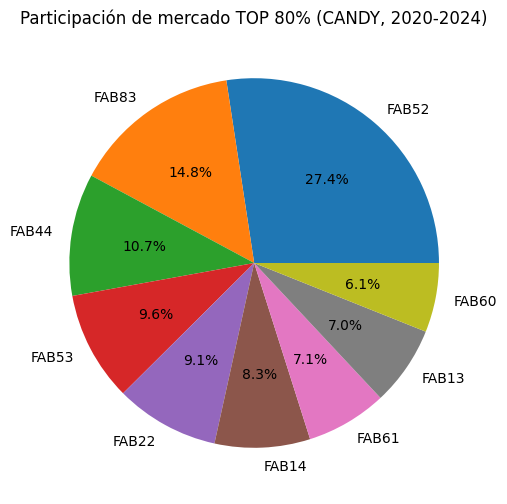

In [5]:
# --- Pie chart con top 80% ---
plt.figure(figsize=(8,6))
plt.pie(df_candy_fab_top['TOTAL'], labels=df_candy_fab_top['FAB'], autopct='%1.1f%%')
plt.title("Participación de mercado TOP 80% (CANDY, 2020-2024)")
plt.show()

FAB52 y FAB83 son las que tienen una mayor parte del mercado. Sobre todo FAB52 que tiene un 27.4% del 80% del mercado total.

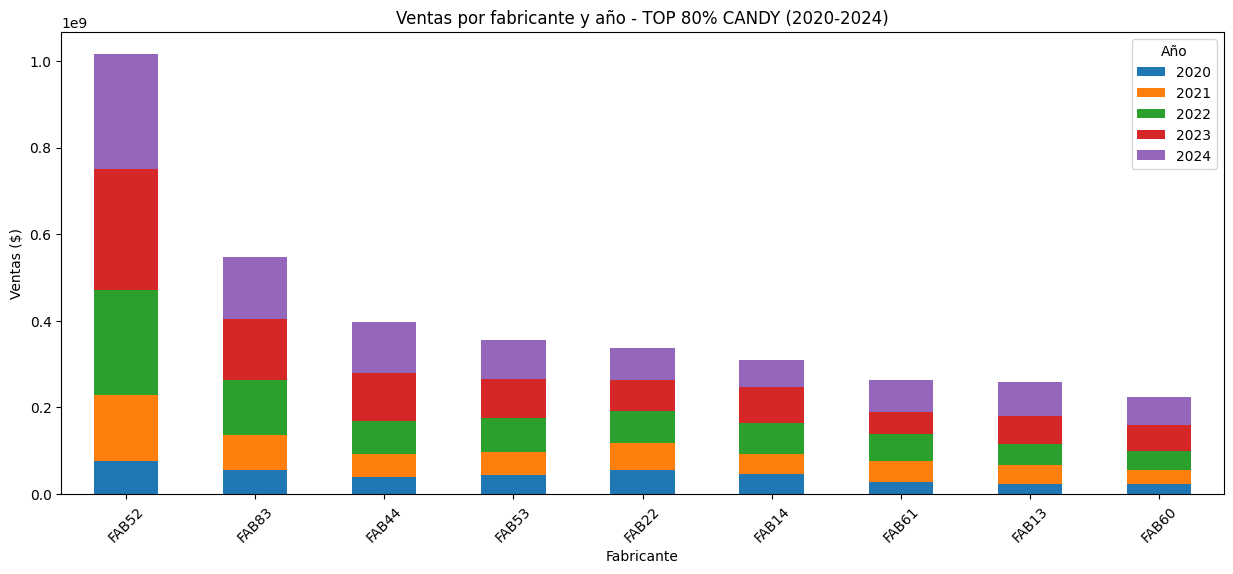

In [8]:
# --- Barras stacked por año solo top 80% ---
fig, ax = plt.subplots(figsize=(15,6))
df_candy_fab_top.set_index('FAB')[['2020','2021','2022','2023','2024']].plot(
    kind='bar', stacked=True, ax=ax
)

ax.set_title("Ventas por fabricante y año - TOP 80% CANDY (2020-2024)")
ax.set_xlabel("Fabricante")
ax.set_ylabel("Ventas ($)")
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.show()

df_candy_fab_top.to_csv('./CANDY_MARKET_SHARE.csv', index=False)

Para el año 2022, FAB52 ya vendía lo las demás FABs en el año 2024. FAB83 en el año 2023 vendía lo que las demás en el año 2024. 

Provide understanding of the candy category by manufacturer sales and price performance over time.

In [9]:
# --- Partimos de df_sales (todas las ventas) y df_catalog ---
# Filtrar solo CANDY
df_catalog_candy = df_catalog[df_catalog['CATEGORY'] == 'CANDY']

# Merge para quedarnos con info de FAB en las ventas
df_candy_sales = df_sales.merge(df_catalog_candy[['ID','FAB']], on='ID', how='inner')

# --- Limpieza de UNIDADES ---
df_candy_sales['UNIDADES'] = (
    df_candy_sales['UNIDADES']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# --- Agrupar por FAB y ANIO ---
df_candy_perf = (
    df_candy_sales
    .groupby(['FAB','ANIO'], as_index=False)
    .agg({'VALOR':'sum','UNIDADES':'sum'})
)
df_candy_perf_top = df_candy_perf[df_candy_perf['FAB'].isin(top_fabs)]

# --- Calcular precio promedio ---
df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']

df_candy_perf_top.to_csv('./CANDY_SALES_PERF.csv', index=False)

C:\Users\Imanol\AppData\Local\Temp\ipykernel_7216\4196741909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_candy_perf_top['PRECIO_PROM'] = df_candy_perf_top['VALOR'] / df_candy_perf_top['UNIDADES']


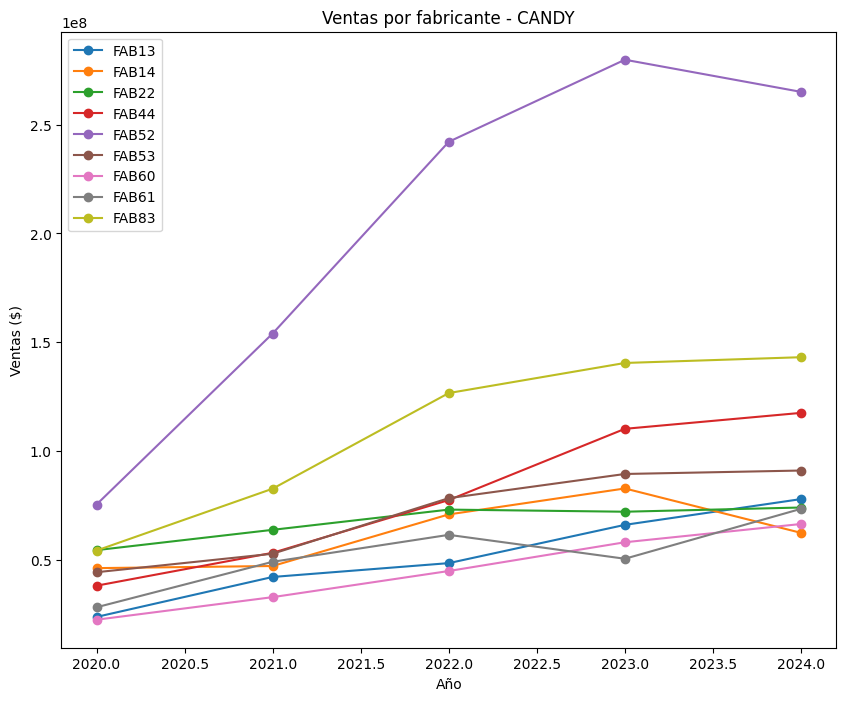

In [10]:
# Gráfico de líneas: ventas por año por fabricante
plt.figure(figsize=(10,8))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['VALOR'], marker='o', label=fab)

plt.title("Ventas por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()

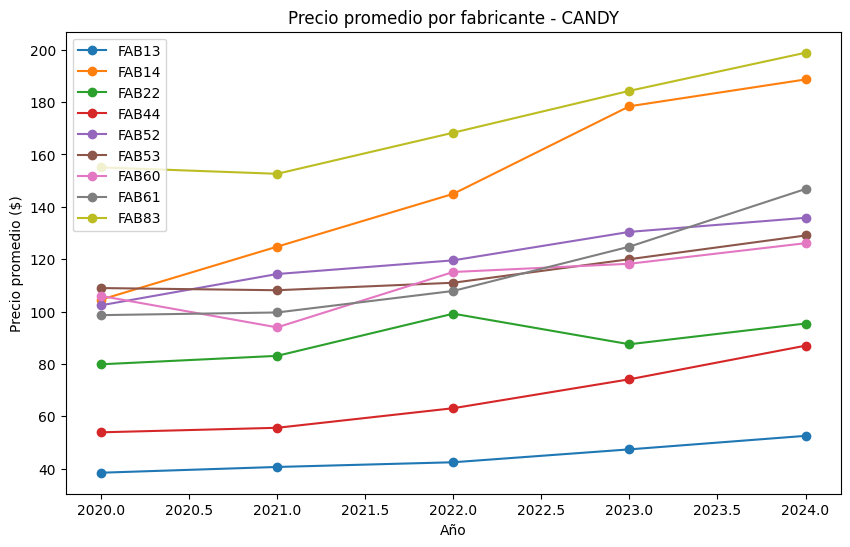

In [11]:
# Gráfico de líneas: precio promedio por año por fabricante
plt.figure(figsize=(10,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.plot(subset['ANIO'], subset['PRECIO_PROM'], marker='o', label=fab)

plt.title("Precio promedio por fabricante - CANDY")
plt.xlabel("Año")
plt.ylabel("Precio promedio ($)")
plt.legend()
plt.show()

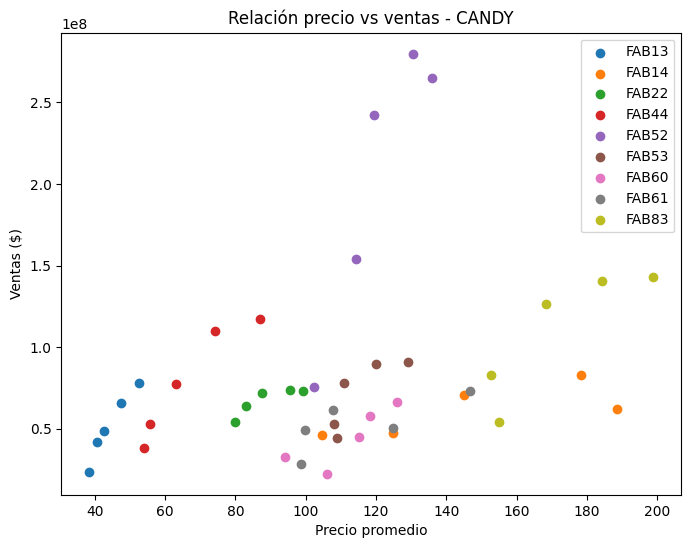

In [12]:
# Gráfico de dispersión: precio promedio vs ventas por fabricante
plt.figure(figsize=(8,6))
for fab in df_candy_perf_top['FAB'].unique():
    subset = df_candy_perf_top[df_candy_perf_top['FAB'] == fab]
    plt.scatter(subset['PRECIO_PROM'], subset['VALOR'], label=fab)

plt.title("Relación precio vs ventas - CANDY")
plt.xlabel("Precio promedio")
plt.ylabel("Ventas ($)")
plt.legend()
plt.show()